# Let's play with the SDV !

### What is the Synthetic Data Vault (SDV) ?
The SDV is a synthetic data generator for relational databases. It allows us to create artificial databases that mimic the data structure of the original ones.

### Why SDV ?
Before SDV all data generation systems depended on how that data was going to be processed. With SDV this is no longer an necessary: the Synthetic Data Vault has the capability to generate data that resembles the original one without any data preprocessing, and the output keeps the original structure.

Also, data privacy has been an issue for the last years. A company may want to hire independent data scientists to analyze the data wihtout compromising privacy or share some data in a annonymized way. The SDV also allows us to re-build the database according to special needs, from quantity of data to proportion of some specifications of the data (say for example a data sample of 70%man 30%women, SDV can allow us to genate data to predict how a 50/50 population will behave and build a database any size we want). 

### How does it work ?
To generate synthetic databases SDV first requires to introduce all data from the tables and include one metadata file specifying parent-child relationships between tables and some data properties for each table. After that, SDV modeler will find child tables that don't 'parent' any other tables. From there, for each column it calculates the distribution (Gaussian, Truncated Gaussian, Uniform, Beta or Exponential). Now we want to find the relationships between columns but the shape of the different distributions may alter covariance estimates. To avoid that SDV transforms each row to standard normal distribution using multivariate Gaussian Copula and then compute the covariance matrix. Covariance matrix together with distribution type and parameters is stored and becomes the generative model for the table.

Now it moves to the respective parent tables and repeats the similar operations with the added data from its child table. First, for each key value of the parent table SDV algorythm finds all it's child refferences in different child tables. For each child table in for each key, it performs the same transformations operations explained above, returning a covariance matrix and its distribution properties. Then all that data for each child data associated with each key value in the parent table is stored in new columns in the parent table (yes, that makes a loong new table). After iterating this process for each child data associated to each key in parent table, SDV will perform the same transformation operations to the new table (including the child covariances and data stored in new columns) and return the corresponding generative model for this table as a covariance matrix with it's associated distributions.

This process is repeated through each parent-child relationship until there are no more parent tables, hence obtaining a generator for each table in the model. This we If we want to generate the complete model, we just have to specify the number of rows we want in the initial table and SDV will generate all the structure for us. All this process is possible even for some non-numerical values (like dates and categories) because of SDV has the capacity to transform the data to numerical, operate it, and then return it to initial data type. It also has the option to generate single tables, generate specifically biased data and generate fake names, credit card IDs... through using the Faker package.

You can read original SDV paper from MIT here https://dai.lids.mit.edu/wp-content/uploads/2018/03/SDV.pdf
and access SDV documentation here https://sdv-dev.github.io/SDV/.

### First, let's grab some data.
We will use data of AirBnb in Barcelona. You can dowload it directly from their website:
http://insideairbnb.com/get-the-data.html.

In [1]:
import pandas as pd
import numpy as np

###### Loading data.

In [2]:
listings_cols = ['id','host_id','neighbourhood_group_cleansed','latitude','longitude'
                 ,'room_type','price','number_of_reviews','last_review','reviews_per_month']
calendar_cols = ['date','available','adjusted_price','listing_id',]
reviews_cols = ['id','date','listing_id','reviewer_name']



listings = pd.read_csv('data/listings.csv',usecols = listings_cols)
calendar = pd.read_csv('data/calendar.csv',usecols = calendar_cols)
reviews = pd.read_csv('data/reviews.csv',usecols = reviews_cols)

###### Formating data.

In [3]:
#LISTING
listings['price'] = listings['price'].str.replace('$','').str.replace(',','').astype(float)
listings['last_review'] = pd.to_datetime(listings['last_review'],format='%Y-%m-%d')
listings = listings.rename(columns = {'id':'listing_id'
                                     ,'neighbourhood_group_cleansed':'neighbourhood'})
#CALENDAR
#need id for sdv
calendar['calendar_id'] = calendar.index
calendar.loc[calendar['available']=='f','available'] = False
calendar.loc[calendar['available']=='t','available'] = True
calendar['date'] = pd.to_datetime(calendar['date'],format='%Y-%m-%d')
calendar['adjusted_price'] = calendar['adjusted_price'].str.replace('$','').str.replace(',','').astype(float)
calendar = calendar.rename(columns={'date':'calendar_date'})
calendar_order = ['calendar_id','calendar_date','available','adjusted_price','listing_id',]
calendar = calendar[calendar_order]

#REVIEWS
reviews['date'] = pd.to_datetime(reviews['date'],format='%Y-%m-%d')
reviews = reviews.rename(columns={'id':'review_id'
                                 ,'date':'review_date'})

###### Here we can see the tables we will be using.

In [4]:
from IPython.display import display
display(listings.head())
display(calendar.head())
display(reviews.head())

,listing_id,host_id,neighbourhood,latitude,longitude,room_type,price,number_of_reviews,last_review,reviews_per_month
0,21974,73163,Ciutat Vella,41.38077,2.17551,Private room,60.0,2,2017-11-06,0.05
1,23197,90417,Sant Martí,41.41291,2.22063,Entire home/apt,220.0,52,2019-12-15,0.47
2,31958,136853,Gràcia,41.40950,2.15938,Entire home/apt,58.0,188,2020-03-09,1.67
3,32471,136853,Gràcia,41.40928,2.16112,Entire home/apt,66.0,94,2020-03-07,0.83
4,32711,135703,Gràcia,41.40566,2.17015,Entire home/apt,140.0,63,2020-02-22,0.59


,calendar_id,calendar_date,available,adjusted_price,listing_id
0,0,2020-05-11,False,135.0,513825
1,1,2020-05-12,False,44.0,515230
2,2,2020-05-13,False,44.0,515230
3,3,2020-05-14,False,44.0,515230
4,4,2020-05-15,False,44.0,515230


,listing_id,review_id,review_date,reviewer_name
0,21974,152431809,2017-05-16,Dries
1,21974,209855799,2017-11-06,Casa De La Unica
2,23197,199839,2011-03-15,Tim
3,23197,857673,2012-01-11,Aaron
4,23197,40030652,2015-07-27,Thomas


###### See properties for each table.

In [5]:
display(listings.info())
display(calendar.info())
display(reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20858 entries, 0 to 20857
Data columns (total 10 columns):
listing_id           20858 non-null int64
host_id              20858 non-null int64
neighbourhood        20858 non-null object
latitude             20858 non-null float64
longitude            20858 non-null float64
room_type            20858 non-null object
price                20858 non-null float64
number_of_reviews    20858 non-null int64
last_review          15511 non-null datetime64[ns]
reviews_per_month    15511 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 1.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7614007 entries, 0 to 7614006
Data columns (total 5 columns):
calendar_id       int64
calendar_date     datetime64[ns]
available         bool
adjusted_price    float64
listing_id        int64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 239.6 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722841 entries, 0 to 722840
Data columns (total 4 columns):
listing_id       722841 non-null int64
review_id        722841 non-null int64
review_date      722841 non-null datetime64[ns]
reviewer_name    722841 non-null object
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 22.1+ MB


None

###### Begining with the SDV. First we create and fill in metadata* instance for the SDV. 

\*For issues with datetime data type  fields and metadata validation please see apendix at the end of the article.

In [6]:
from sdv import Metadata

In [7]:
reviews_fields = {
#using Faker for names
    'reviewer_name': {
        'type': 'categorical',
        'pii': True,
        'pii_category': 'first_name'
    }
} 

In [8]:
metadata = Metadata()

metadata.add_table('listings',data=listings,primary_key='listing_id')
metadata.add_table('reviews',data=reviews,primary_key='review_id',parent='listings', foreign_key='listing_id')
metadata.add_table('calendar',data=calendar,primary_key='calendar_id',parent='listings',
                   fields_metadata = reviews_fields, foreign_key='listing_id')

metadata.validate()

###### Behold our data structure !!!

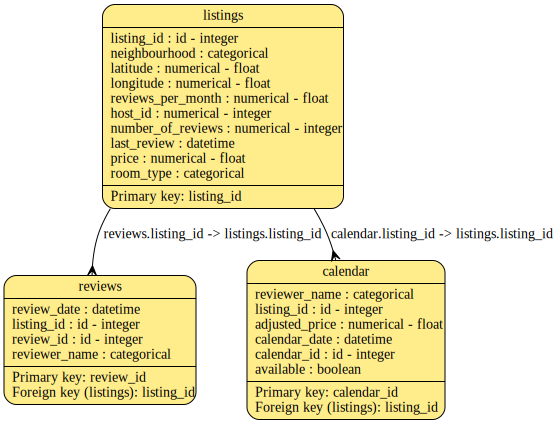

In [9]:
metadata.visualize()

###### Creating a new SDV model with current tables and metadata.

In [10]:
from sdv import SDV

In [11]:
'''
#create and save new model
tables = {'listings':listings,'reviews':reviews,'calendar':calendar}
sdv = SDV()
sdv.fit(metadata,tables)
sdv.save('meta_fit/bcnfit2.pk1')
'''

# It is possible to use an already trained model
sdv = SDV.load('meta_fit/bcnfit1.pk1')


###### Once it is fitted we will create a synthetic database same size as the original.

In [12]:
ListingsRows = listings['listing_id'].count()
print("Original parent table 'listings' has {} rows.".format(ListingsRows))

Original parent table 'listings' has 20858 rows.


In [13]:
'''
#sampling new tables 
sample = sdv.sample_all(ListingsRows)

#saving into .csv files
sample['listings'].to_csv('synth_tables/newListings2.csv', index= False)
sample['calendar'].to_csv('synth_tables/newCalendar2.csv', index = False)
sample['reviews'].to_csv('synth_tables/newReviews2.csv', index = False)
'''

#can load from already generated .csv
sample = {}
sample['listings'] = pd.read_csv('synth_tables/newListings.csv')
sample['calendar'] = pd.read_csv('synth_tables/newCalendar.csv')
sample['reviews'] = pd.read_csv('synth_tables/newReviews.csv')

###### Now we can see our new database

In [14]:
#Defining synthetic as new
newListings = sample['listings']
newCalendar = sample['calendar']
newReviews = sample['reviews']

display(newListings.head())
display(newCalendar.head())
display(newReviews.head())


,room_type,neighbourhood,latitude,price,last_review,listing_id,longitude,host_id,number_of_reviews,reviews_per_month
0,Private room,Sants-Montjuïc,41.374350,-1.040110,NaN,208,2.154534,146177327,54,NaN
1,Entire home/apt,Eixample,41.387719,206.965888,NaN,209,2.160008,134860278,-23,NaN
2,Entire home/apt,Sants-Montjuïc,41.397209,164.451282,NaN,210,2.155072,100317613,-3,NaN
3,Entire home/apt,Ciutat Vella,41.381836,413.669416,2018-11-05 19:03:35.426610688,211,2.153186,49296443,63,1.906663
4,Entire home/apt,Sants-Montjuïc,41.408264,97.994302,NaN,212,2.175205,197892351,28,NaN


,listing_id,calendar_id,available,calendar_date,adjusted_price
0,208,75921,False,2020-12-13 13:45:20.681295616,-630.549174
1,208,75922,True,2020-11-18 09:08:45.284537088,-630.550781
2,208,75923,True,2020-10-23 16:55:30.249695488,-630.587328
3,208,75924,True,2020-07-18 06:43:38.989393152,-630.599708
4,208,75925,True,2020-12-04 08:00:48.737202688,-630.498592


,reviewer_name,review_date,review_id,listing_id
0,Justin,2017-08-10 00:10:45.649241344,11221,208
1,Holly,2017-08-10 00:10:40.158142720,11222,208
2,Kristine,2017-08-10 00:10:46.449014784,11223,208
3,Kimberly,2017-08-10 00:10:40.474137088,11224,208
4,Nicole,2017-08-10 00:10:38.108412160,11225,208


###### Time to compare both databases.

In [15]:
#Counting entries for all
ReviewsRows = reviews['review_id'].count()
CalendarRows = calendar['calendar_id'].count()
newListingsRows = newListings['listing_id'].count()
newReviewsRows = newReviews['review_id'].count()
newCalendarRows = newCalendar['calendar_id'].count()

eList = abs(ListingsRows-newListingsRows)/ListingsRows*100
eRev = abs(ReviewsRows-newReviewsRows)/ReviewsRows*100
eCal = abs(CalendarRows-newCalendarRows)/CalendarRows*100
#print Info
print('ROW_COUNT \n')
print('listings:{}, newListings: {}.'.format(ListingsRows,newListingsRows))
print('Difference: {0:.2f}%.\n'.format(eList))
print('reviews:{}, newReviews: {}.'.format(ReviewsRows,newReviewsRows))
print('Difference: {0:.2f}%.\n'.format(eRev))
print('calendar:{}, newCalendar: {}.'.format(CalendarRows,newCalendarRows))
print('Difference: {0:.2f}%.\n'.format(eCal))

ROW_COUNT 

listings:20858, newListings: 20858.
Difference: 0.00%.

reviews:722841, newReviews: 956202.
Difference: 32.28%.

calendar:7614007, newCalendar: 7613295.
Difference: 0.01%.



###### We can see SDV has been quite accurate for 2 of our 3 tables. For 'reviews' table SDV has generated 32% more entries than the original table.

###### Let's analyze the data.

In [16]:
listings_order = ['listing_id','host_id','neighbourhood','latitude','longitude','room_type','price'
                  ,'number_of_reviews','last_review','reviews_per_month']
newListings = newListings[listings_order]
newListings['price'] = newListings['price'].round(2)
from IPython.display import display
display(listings.info())
display(newListings.info())
display(listings.head())
display(newListings.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20858 entries, 0 to 20857
Data columns (total 10 columns):
listing_id           20858 non-null int64
host_id              20858 non-null int64
neighbourhood        20858 non-null object
latitude             20858 non-null float64
longitude            20858 non-null float64
room_type            20858 non-null object
price                20858 non-null float64
number_of_reviews    20858 non-null int64
last_review          15511 non-null datetime64[ns]
reviews_per_month    15511 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 1.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20858 entries, 0 to 20857
Data columns (total 10 columns):
listing_id           20858 non-null int64
host_id              20858 non-null int64
neighbourhood        20858 non-null object
latitude             20858 non-null float64
longitude            20858 non-null float64
room_type            20858 non-null object
price                20858 non-null float64
number_of_reviews    20858 non-null int64
last_review          14754 non-null object
reviews_per_month    14754 non-null float64
dtypes: float64(4), int64(3), object(3)
memory usage: 1.6+ MB


None

,listing_id,host_id,neighbourhood,latitude,longitude,room_type,price,number_of_reviews,last_review,reviews_per_month
0,21974,73163,Ciutat Vella,41.38077,2.17551,Private room,60.0,2,2017-11-06,0.05
1,23197,90417,Sant Martí,41.41291,2.22063,Entire home/apt,220.0,52,2019-12-15,0.47
2,31958,136853,Gràcia,41.40950,2.15938,Entire home/apt,58.0,188,2020-03-09,1.67
3,32471,136853,Gràcia,41.40928,2.16112,Entire home/apt,66.0,94,2020-03-07,0.83
4,32711,135703,Gràcia,41.40566,2.17015,Entire home/apt,140.0,63,2020-02-22,0.59


,listing_id,host_id,neighbourhood,latitude,longitude,room_type,price,number_of_reviews,last_review,reviews_per_month
0,208,146177327,Sants-Montjuïc,41.374350,2.154534,Private room,-1.04,54,NaN,NaN
1,209,134860278,Eixample,41.387719,2.160008,Entire home/apt,206.97,-23,NaN,NaN
2,210,100317613,Sants-Montjuïc,41.397209,2.155072,Entire home/apt,164.45,-3,NaN,NaN
3,211,49296443,Ciutat Vella,41.381836,2.153186,Entire home/apt,413.67,63,2018-11-05 19:03:35.426610688,1.906663
4,212,197892351,Sants-Montjuïc,41.408264,2.175205,Entire home/apt,97.99,28,NaN,NaN


###### As we can see data type preserves for each field except 'last_review' which is now object type. We had some issues with data format for date and other fields from this dataset (see apendix) and here is manifested as full date instead of only '%Y-%m-%d' format. 
###### Categorical values seem to alright. We can see SDV generates NaN values in similar proportion as the original database for fields 'last_review' and 'reviews_per_months'.
###### We can see some negative values for 'price'  and 'number_of_reviews'. It will be interesting to check for negatives in 'longitude' and 'latitude' too. This could be due SDV distribution-like type functioning. Altough SDV can store parameters for the distribution of the field, it doesn't allow for a 'non-negative' option, thus leading to some results that although are within theoretical distribution shape, it may not match a realistic result. 'price', for example, can't be negative.

In [17]:
display(newListings.loc[newListings['latitude']<0])
display(newListings.loc[newListings['longitude']<0])

,listing_id,host_id,neighbourhood,latitude,longitude,room_type,price,number_of_reviews,last_review,reviews_per_month


,listing_id,host_id,neighbourhood,latitude,longitude,room_type,price,number_of_reviews,last_review,reviews_per_month


###### 'latitude' and 'longitude' fields seem to be alright. We can plot the values in a map of the city.

In [18]:
# Plotting the data
import matplotlib.pyplot as plt
##edit this later
#auto_coords=(listings.longitude.min(),listings.longitude.max(),listings.latitude.min(),listings.latitude.max())
manual_coords = ( 2.0778 , 2.2306 , 41.3495 , 41.4640 )
box = (manual_coords)
background = plt.imread('data/map_bcn.png')

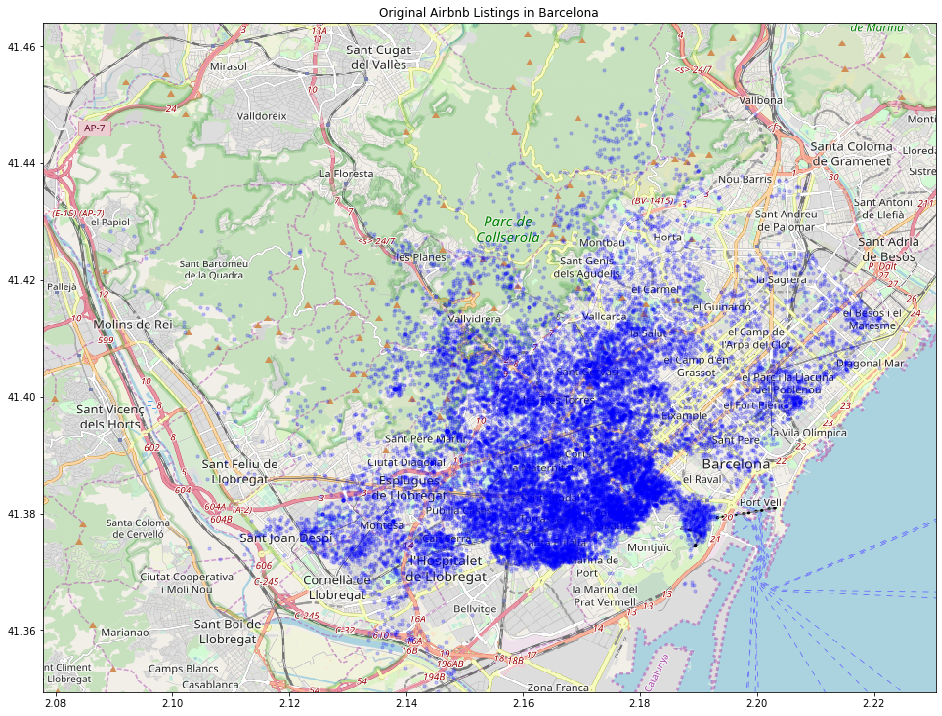

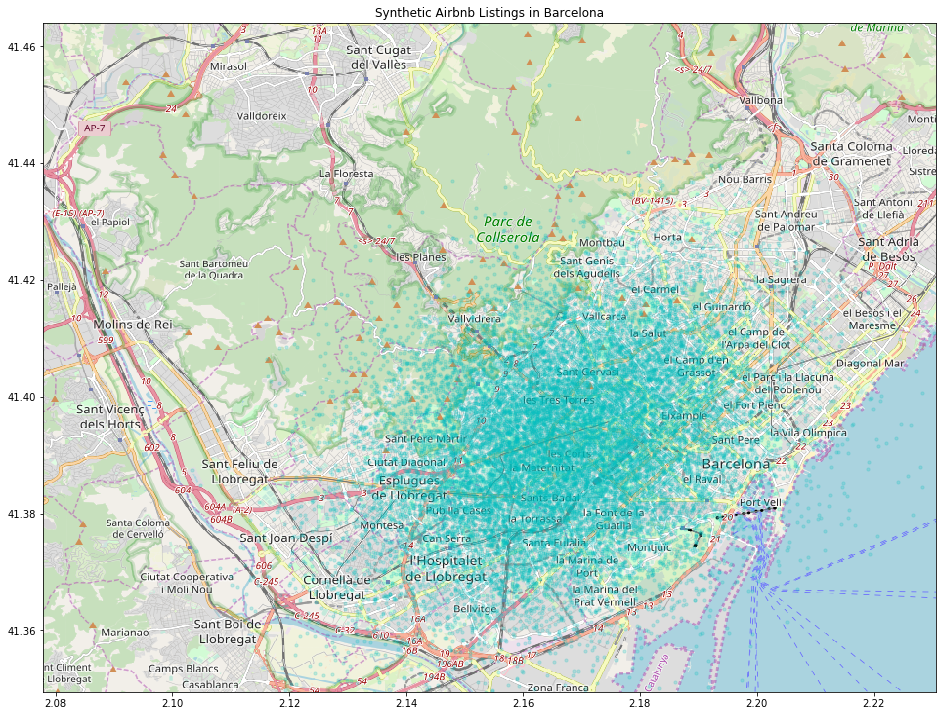

In [19]:
#original data plot
fig, ax = plt.subplots(figsize = (16,14))
Long, Lat= (listings.longitude, listings.latitude)
ax.scatter(Long, Lat,zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title("Original Airbnb Listings in Barcelona")
ax.set_xlim(box[0],box[1])
ax.set_ylim(box[2],box[3])
ax.imshow(background, zorder=0, extent = box, aspect= 'equal')

#synthetic data plot
fig, ax = plt.subplots(figsize = (16,14))
Long, Lat= (newListings.longitude, newListings.latitude)
ax.scatter(Long, Lat,zorder=1, alpha= 0.2, c='c', s=10)
ax.set_title("Synthetic Airbnb Listings in Barcelona")
ax.set_xlim(box[0],box[1])
ax.set_ylim(box[2],box[3])
ax.imshow(background, zorder=0, extent = box, aspect= 'equal')

###### We can see that synthetic new listings location seem to spread from a central point.  See below data distribution comparison for 'latitude' and 'longitude'.


Distributions for Latitude and Longitude.


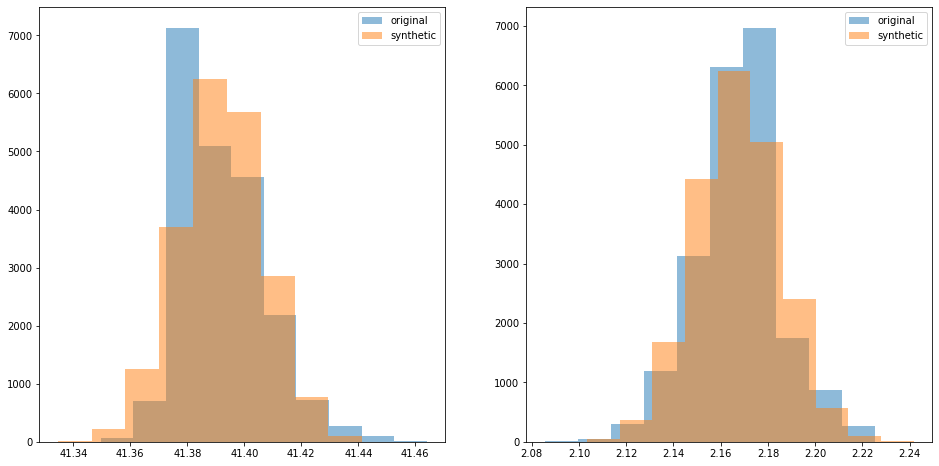

In [20]:
f = plt.figure(figsize = (16,8))

ax1 = plt.subplot(121)
ax1.hist(listings['latitude'],alpha=0.5,label='original')
ax1.hist(newListings['latitude'],alpha=0.5,label='synthetic')
ax1.legend()

ax2 = plt.subplot(122)
ax2.hist(listings['longitude'], alpha=0.5,label='original')
ax2.hist(newListings['longitude'], alpha=0.5,label='synthetic')
ax2.legend()


print('\nDistributions for Latitude and Longitude.')

In [21]:
display(listings.describe())
display(newListings.describe())

,listing_id,host_id,latitude,longitude,price,number_of_reviews,reviews_per_month
count,2.085800e+04,2.085800e+04,20858.000000,20858.000000,20858.000000,20858.000000,15511.000000
mean,2.523653e+07,1.104806e+08,41.391938,2.167530,124.210711,34.655336,1.369111
std,1.351890e+07,1.108776e+08,0.014901,0.017816,405.947246,64.189641,1.439218
min,2.197400e+04,3.073000e+03,41.349670,2.085520,0.000000,0.000000,0.010000
25%,1.446349e+07,9.740573e+06,41.380290,2.156973,36.000000,0.000000,0.290000
50%,2.679178e+07,6.304730e+07,41.388785,2.168280,59.000000,6.000000,0.870000
75%,3.756168e+07,1.958453e+08,41.401920,2.178020,100.000000,39.000000,2.070000
max,4.340439e+07,3.458752e+08,41.464010,2.225520,9034.000000,731.000000,27.980000


,listing_id,host_id,latitude,longitude,price,number_of_reviews,reviews_per_month
count,20858.000000,2.085800e+04,20858.000000,20858.000000,20858.000000,20858.000000,14754.000000
mean,10636.500000,1.096988e+08,41.392093,2.167548,123.681336,34.046888,1.372947
std,6021.330293,1.115136e+08,0.014827,0.017790,146.197259,63.355199,1.192324
min,208.000000,-3.349183e+08,41.334555,2.103359,-440.000000,-206.000000,-2.957570
25%,5422.250000,3.376352e+07,41.382086,2.155527,26.635000,-9.000000,0.570393
50%,10636.500000,1.092588e+08,41.392134,2.167419,123.360000,34.000000,1.371017
75%,15850.750000,1.853467e+08,41.402181,2.179629,221.402500,76.000000,2.174512
max,21065.000000,5.640626e+08,41.453282,2.241721,775.770000,286.000000,6.775135


###### 'latitude' and 'longitude' vaues seem withing range. All values seem to preserve the mean. 'price', 'number_of_reviews' and 'reviews_per_month' vary in range, reaching negative values.

Text(0, 0.5, 'Number of Listings')

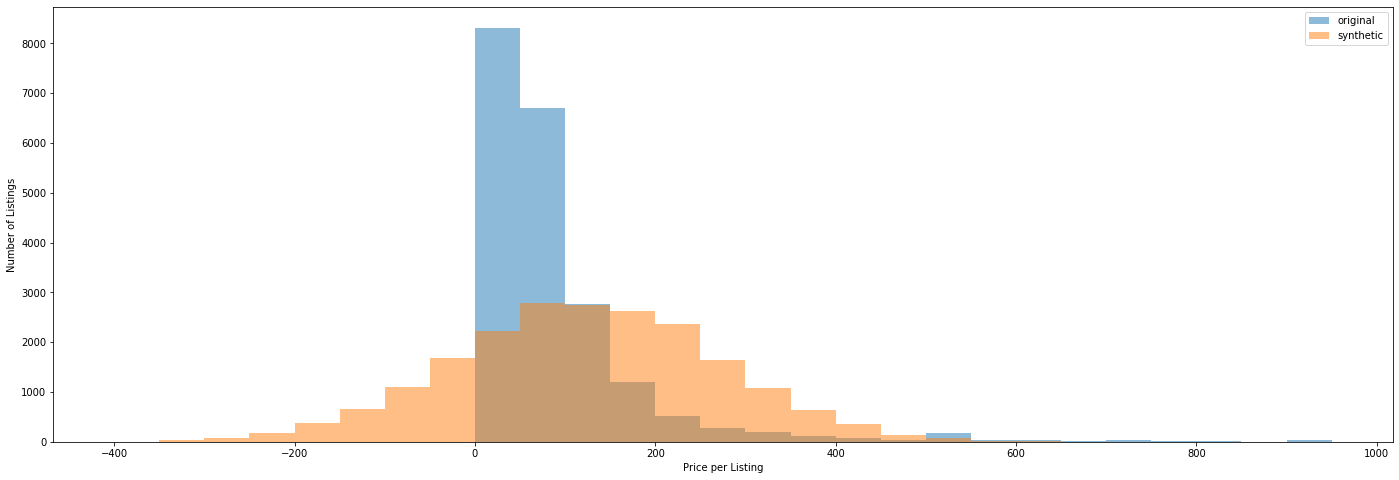

In [22]:
f = plt.figure(figsize = (24,8))

xs = list(range(-400,1000,50))
ax1 = plt.subplot()
ax1.hist(listings['price'],alpha=0.5,label='original',bins=xs)
ax1.hist(newListings['price'],alpha=0.5,label='synthetic',bins=xs)
ax1.legend()
ax1.set_xlabel('Price per Listing')
ax1.set_ylabel('Number of Listings')

Text(0, 0.5, 'Number of Listings')

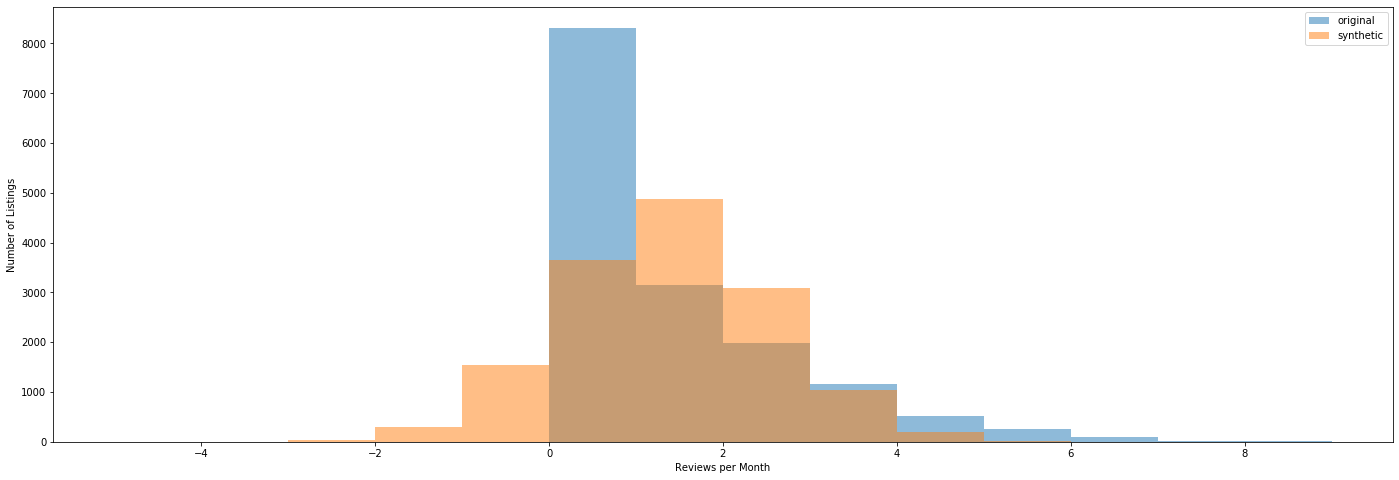

In [23]:
f = plt.figure(figsize = (24,8))

xs = list(range(-5,10,1))
ax1 = plt.subplot()
ax1.hist(listings['reviews_per_month'],alpha=0.5,label='original',bins=xs)
ax1.hist(newListings['reviews_per_month'],alpha=0.5,label='synthetic',bins=xs)
ax1.legend()
ax1.set_xlabel('Reviews per Month')
ax1.set_ylabel('Number of Listings')

###### Both fields 'price' and 'reviews_per_month' seem to have different distributions after synthetic generation, including new presence of negative values.

###### Let's see 'reviews' table.

In [24]:
# Let's see reviews table
reviews_order = ['review_id','review_date','listing_id','reviewer_name']
newReviews = newReviews[reviews_order]
display(reviews.info())
display(newReviews.info())
display(reviews.head())
display(newReviews.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722841 entries, 0 to 722840
Data columns (total 4 columns):
listing_id       722841 non-null int64
review_id        722841 non-null int64
review_date      722841 non-null datetime64[ns]
reviewer_name    722841 non-null object
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 22.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956202 entries, 0 to 956201
Data columns (total 4 columns):
review_id        956202 non-null int64
review_date      770351 non-null object
listing_id       956202 non-null int64
reviewer_name    956202 non-null object
dtypes: int64(2), object(2)
memory usage: 29.2+ MB


None

,listing_id,review_id,review_date,reviewer_name
0,21974,152431809,2017-05-16,Dries
1,21974,209855799,2017-11-06,Casa De La Unica
2,23197,199839,2011-03-15,Tim
3,23197,857673,2012-01-11,Aaron
4,23197,40030652,2015-07-27,Thomas


,review_id,review_date,listing_id,reviewer_name
0,11221,2017-08-10 00:10:45.649241344,208,Justin
1,11222,2017-08-10 00:10:40.158142720,208,Holly
2,11223,2017-08-10 00:10:46.449014784,208,Kristine
3,11224,2017-08-10 00:10:40.474137088,208,Kimberly
4,11225,2017-08-10 00:10:38.108412160,208,Nicole


###### Here we used Faker package in SDV to generate fake names for our column 'reviewer_name'. It has worked successfully. See appendix below for datatype problems with the database ('review_date' field in this case).

###### Now 'calendar' table.

In [25]:
calendar_order = ['calendar_id','calendar_date','available','adjusted_price','listing_id']
newCalendar = newCalendar[calendar_order]
newCalendar['adjusted_price'] = newCalendar['adjusted_price'].round(2)
display(calendar.info())
display(newCalendar.info())
display(calendar.head())
display(newCalendar.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7614007 entries, 0 to 7614006
Data columns (total 5 columns):
calendar_id       int64
calendar_date     datetime64[ns]
available         bool
adjusted_price    float64
listing_id        int64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 239.6 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613295 entries, 0 to 7613294
Data columns (total 5 columns):
calendar_id       int64
calendar_date     object
available         bool
adjusted_price    float64
listing_id        int64
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 239.6+ MB


None

,calendar_id,calendar_date,available,adjusted_price,listing_id
0,0,2020-05-11,False,135.0,513825
1,1,2020-05-12,False,44.0,515230
2,2,2020-05-13,False,44.0,515230
3,3,2020-05-14,False,44.0,515230
4,4,2020-05-15,False,44.0,515230


,calendar_id,calendar_date,available,adjusted_price,listing_id
0,75921,2020-12-13 13:45:20.681295616,False,-630.55,208
1,75922,2020-11-18 09:08:45.284537088,True,-630.55,208
2,75923,2020-10-23 16:55:30.249695488,True,-630.59,208
3,75924,2020-07-18 06:43:38.989393152,True,-630.60,208
4,75925,2020-12-04 08:00:48.737202688,True,-630.50,208


###### Here we find negative values in price too.

In [26]:
display(calendar['available'].describe())
display(newCalendar['available'].describe())

count     7614007
unique          2
top          True
freq      4223945
Name: available, dtype: object

count     7613295
unique          2
top          True
freq      4697801
Name: available, dtype: object

###### Similar. Let's see 'date'.

In [27]:
newCalendar.sort_values(by=['calendar_date'])

,calendar_id,calendar_date,available,adjusted_price,listing_id
5776148,5852069,2019-05-15 02:11:30.432814848,True,574.62,16032
7278373,7354294,2019-05-15 16:32:05.232611584,True,-292.59,20148
6125289,6201210,2019-06-06 20:57:03.954959872,True,282.11,16989
4423839,4499760,2019-06-08 04:27:45.561943296,True,-307.98,12327
1466680,1542601,2019-06-10 03:06:45.762929920,True,-1.02,4226
5722191,5798112,2019-06-11 03:44:14.223219712,True,559.03,15885
4303857,4379778,2019-06-11 21:20:09.052782336,True,-341.26,11999
4716288,4792209,2019-06-15 01:22:58.846888192,False,-169.60,13129
6414903,6490824,2019-06-16 00:53:36.924742656,True,-132.87,17782
1964882,2040803,2019-06-16 05:50:06.226263296,True,-103.15,5591


In [28]:
print("calendar['calendar_date']\nEarliest: {}.\nLatest: {}".format(calendar.calendar_date.min(),calendar.calendar_date.max()))

calendar['calendar_date']
Earliest: 2020-05-11 00:00:00.
Latest: 2021-05-11 00:00:00


###### In the original calendar we have dates circa 2020-2021, in the generated calendar we have dates from past 2019 to 2022. This could be due date datatype processing errors or synthetic generation. We can also see that original data is ordered and sequenced. This may be difficult for SDV randomized generation. One option could be to try 'calendar_date' as category for this table.*

\* format was not preserved for datetime fields, please see apendix at the end of the article explaining data formatting and validation issues.

### Conclusion

SDV preserved the structure of the relational database tables, allowed us to generate some values and even fake names. However, acccuracy of the generated data was compromised. Coordinates would not match and some fields did not preserve the distribution.
We also had some issues formatting this data (see apendix below) and that may have altered the results. Further evaluations with new datasets or appropiately formatted data are required.

### Apendix

Metadata with a for datetime data type wouldn't validate. It would validate if we didn't specify subtype.

In [29]:
metadata = Metadata()

In [30]:
listings_fields = {
    'last_review' :{
        'type': 'datetime',
        'subtype': '%Y-%m-%d'
    }
}

reviews_fields = {
        'review_date' :{
        'type': 'datetime',
        'subtype': '%Y-%m-%d'
    }, # using Faker for names
    
    'reviewer_name': {
        'type': 'categorical',
        'pii': True,
        'pii_category': 'first_name'
    }
} 

calendar_fields = {
    'calendar_date' :{
        'type': 'datetime',
        'subtype': '%Y-%m-%d'
    }
}

In [31]:
metadata = Metadata()

metadata.add_table('listings',data=listings,primary_key='listing_id',
                   fields_metadata = listings_fields 
                   ## would not validate
                  )
metadata.add_table('reviews',data=reviews,primary_key='review_id',
                   fields_metadata = reviews_fields,
                   parent='listings', foreign_key='listing_id')
metadata.add_table('calendar',data=calendar,primary_key='calendar_id',
                   fields_metadata = calendar_fields,
                   parent='listings', foreign_key='listing_id')

metadata.validate()

MetadataError: Invalid type and subtype combination for field last_review: (datetime, %Y-%m-%d)

I could not resolve this issue. Maybe there is a possibility that this could have compromised SDV model fitting process and structure of data generated.

\** Note on datetime: I found full datetime format generation (year,month,day,hour,minute...) was not particular to my dataset.

\*** Note on negative int and float values: I found the generation of negative values in the synthetic dataset was not particular to my dataset.

Please see https://github.com/sdv-dev/SDV/blob/master/examples/Demo%20-%20Walmart.ipynb to find similar results. SDV is still in a pre-alpha version, more updates will be coming soon.